# Using `torch.datapipes`

Let's try to load `CamVid`...

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from fastcore.all import *

import torchdata.datapipes.iter as pipes
from torch.utils.data.datapipes.utils.decoder import imagehandler
from torchdata.datapipes.iter import FileOpener, IterableWrapper, Mapper, RoutedDecoder, TarArchiveLoader

In [2]:
# camvid_url = "https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz"
# !wget {camvid_url}

# camvid_path = untar_dir("camvid.tgz", Path("."))

In [3]:
camvid_path = Path("camvid")
camvid_path.ls()

(#4) [Path('camvid/valid.txt'),Path('camvid/codes.txt'),Path('camvid/images'),Path('camvid/labels')]

We have the images in `camvid/images` and the labels in `camvid/labels`

In [4]:
(camvid_path/"images").ls()[0:5], (camvid_path/"labels").ls()[0:5]

((#5) [Path('camvid/images/Seq05VD_f04290.png'),Path('camvid/images/0001TP_009630.png'),Path('camvid/images/0006R0_f02940.png'),Path('camvid/images/0016E5_05250.png'),Path('camvid/images/0016E5_08017.png')],
 (#5) [Path('camvid/labels/0016E5_08250_P.png'),Path('camvid/labels/0006R0_f01080_P.png'),Path('camvid/labels/0016E5_05910_P.png'),Path('camvid/labels/0016E5_06150_P.png'),Path('camvid/labels/Seq05VD_f01680_P.png')])

as we can see the labels are using the same name but with a `_P` suffix.

In [5]:
# from fastai
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = plt.subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

In [6]:
def label_func(fname):
    name = fname.with_suffix("").name + "_P.png"# remove suffix
    return fname.parent.parent/f"labels/{name}"

In [7]:
label_func((camvid_path/"images").ls()[0])

Path('camvid/labels/Seq05VD_f04290_P.png')

In [8]:
from torch.utils.data import Dataset

In [9]:
from torch.utils.data import IterableDataset

In [10]:
class CamVid:
    def __init__(self, path):
        self.path = Path(path)
        self.images = (self.path/"images").ls()
    
    @staticmethod
    def label_func(fname):
        name = fname.with_suffix("").name + "_P.png"# remove suffix
        return fname.parent.parent/f"labels/{name}"
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        pil_image = Image.open(image_path)
        pil_label = Image.open(self.label_func(image_path))
        return pil_image, pil_label
    
    def __len__(self):
        return len(self.images)
    

or in itertable version

In [11]:
class CamVidIter(IterableDataset):
    def __init__(self, path):
        self.path = Path(path)
        self.images = (self.path/"images").iterdir()
        
    def __iter__(self):
        for image_path in self.images:
            pil_image = Image.open(image_path)
            pil_label = Image.open(label_func(image_path))
            yield pil_image, pil_label

In [12]:
ds = CamVidIter(camvid_path)

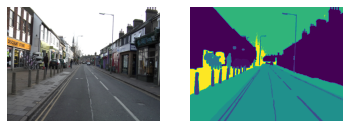

In [13]:
show_images(next(iter(ds)))

In [14]:
ds = CamVid(camvid_path)

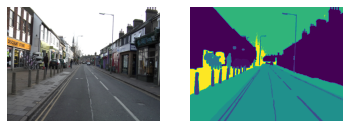

In [15]:
show_images(ds[0])

## Example 1

> Simple pipeline with label func using `Mapper`

In [16]:
dp = pipes.FileLister([camvid_path/"images"], masks="*.png")
next(iter(dp))

'camvid/images/0001TP_006690.png'

In [17]:
def label_func2(fname):
    fname = Path(fname)
    name = fname.with_suffix("").name + "_P.png"# remove suffix
    return fname, fname.parent.parent/f"labels/{name}"

In [18]:
dp = pipes.Mapper(dp, label_func2)
next(iter(dp))

(Path('camvid/images/0001TP_006690.png'),
 Path('camvid/labels/0001TP_006690_P.png'))

In [19]:
def PIL_open(data):
    return Image.open(data[0]), Image.open(data[1])

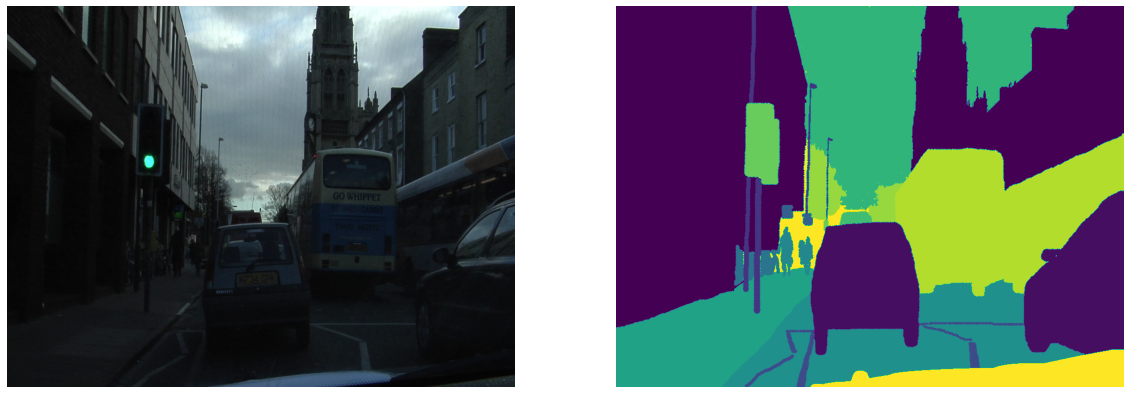

In [20]:
dp = pipes.Mapper(dp, PIL_open)
show_images(next(iter(dp)), figsize=(20,10))

## Example 2

> Putting two pipelines together with `Zipper`

In [67]:
images = pipes.FileLister([camvid_path/"images"], masks="*.png").map(Image.open)
labels = pipes.FileLister([camvid_path/"labels"], masks="*.png").map(Image.open)

In [68]:
ds = pipes.Zipper(images, labels).shuffle().batch(3)

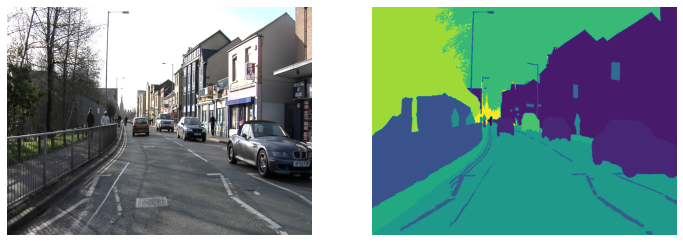

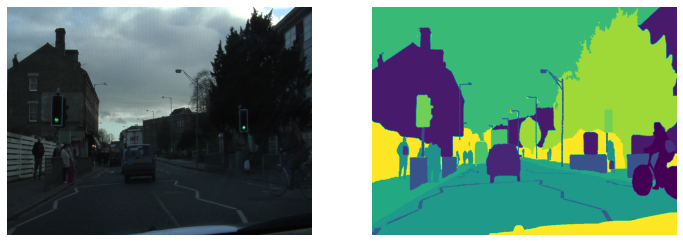

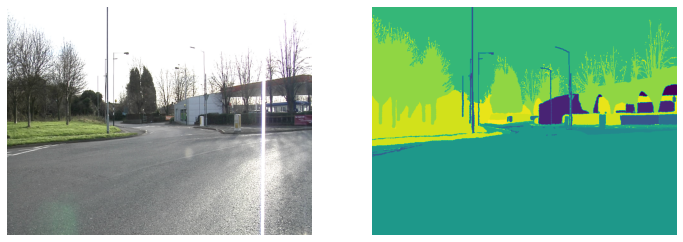

In [69]:
batch = next(iter(ds))
for im, mk in batch:
    show_images([im, mk], figsize=(12,6))

## Example 3

> Reading the tar files directly

In [ ]:
camvid_itertable = pipes.IterableWrapper(["camvid.tgz"])

NameError: name 'pipes' is not defined

In [63]:
tgz = FileOpener(camvid_itertable, mode="b")
next(iter(tgz))

('camvid.tgz', StreamWrapper<<_io.BufferedReader name='camvid.tgz'>>)

In [64]:
files = tgz.load_from_tar()
next(iter(files))

('camvid.tgz/camvid/codes.txt',
 StreamWrapper<<ExFileObject name='camvid.tgz'>>)

In [56]:
images = pipes.Filter(files, filter_fn=lambda tup: Path(tup[0]).parent.name == "images")
labels = pipes.Filter(files, filter_fn=lambda tup: Path(tup[0]).parent.name == "labels")

In [57]:
next(iter(images))

('camvid.tgz/camvid/images/0016E5_00750.png',
 StreamWrapper<<ExFileObject name='camvid.tgz'>>)

In [88]:
images = pipes.RoutedDecoder(images, imagehandler("pil"))
labels = pipes.RoutedDecoder(labels, imagehandler("pill"))  # on mode pil-L

In [82]:
next(iter(images)), next(iter(labels))

(('camvid.tgz/camvid/images/0016E5_00750.png',
  <PIL.Image.Image image mode=RGB size=960x720 at 0x7F6EC9A1A610>),
 ('camvid.tgz/camvid/labels/0001TP_009690_P.png',
  <PIL.Image.Image image mode=L size=960x720 at 0x7F6EC9A1A7F0>))

In [83]:
def get_image_id(data):
    path, _ = data
    return Path(path).name.split(".")[0]

def get_label_id(data):
    path, _ = data
    return Path(path).name.split("_P")[0]

In [84]:
dp = pipes.IterKeyZipper(images, 
                         labels, 
                         get_image_id, 
                         get_label_id)

this is extremely slow...

In [85]:
next(iter(dp))

(('camvid.tgz/camvid/images/0016E5_00750.png',
  <PIL.Image.Image image mode=RGB size=960x720 at 0x7F6EC9A1AF40>),
 ('camvid.tgz/camvid/labels/0016E5_00750_P.png',
  <PIL.Image.Image image mode=L size=960x720 at 0x7F6EC961C250>))

In [86]:
dp = dp.map(lambda x: (x[0][1], x[1][1]))

In [89]:
%timeit next(iter(dp))

6.13 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


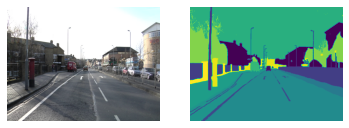

In [87]:
show_images(next(iter(dp)))